# Visualization methods for fsLR5k connectomes

a) The best sorting of an adjacency matrix for visualization purposes is the one that aligns with the methods used in the research.

b) Another option not explored in this notebook, is to sort the matrices based on the the eigenvector of a diffusion embedding.

### References
1. *Diffusion maps*: Coifman, Ronald R., and Stéphane Lafon. "Diffusion maps." Applied and computational harmonic analysis 21.1 (2006): 5-30.
2. *Multidimensional scaling*: Cox, T. F. & Cox, M. A. A. Multidimensional Scaling 2nd edn (Chapman & Hall/CRC, 2001).
3. *Louvain communities*: Zhang, Jicun, et al. "An improved Louvain algorithm for community detection." Mathematical Problems in Engineering 2021.1 (2021): 1485592. [doi: 10.1155/2021/1485592](https://doi.org/10.1155/2021/1485592)
4. *Spectral decomposition:* R. B. Lehoucq, D. C. Sorensen, and C. Yang, ARPACK USERS GUIDE: Solution of Large Scale Eigenvalue Problems by Implicitly Restarted Arnoldi Methods. SIAM, Philadelphia, PA, 1998.

### Libraries

In [1]:
import os
import glob
import copy

import nibabel as nb
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import statsmodels.api as sm
import community as community_louvain
import matplotlib.pyplot as plt

from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from nilearn import plotting
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from scipy.stats import spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess


### Variables

In [2]:
# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native inflated surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# Load the fslr5k pial surface
f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# Load the fsLF5k midwall mask
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

### Functions

In [3]:
def sort_matrix(A, method='degree', indices=None):
    if not isinstance(A, np.ndarray):
        raise ValueError("Input matrix A must be a NumPy array.")
    
    # Primary Sorting based on the method
    if method == 'degree':
        order = np.argsort(np.sum(-A, axis=0))
        
    elif method == 'spectral':
        # Convert to sparse matrix for efficiency
        L = laplacian(A, normed=True)
        L_sparse = csr_matrix(L)

        # Compute the two smallest eigenvalues and corresponding eigenvectors
        # `which='SM'` means Smallest Magnitude
        _, eigenvectors = eigsh(L_sparse, k=2, which='SM')

        # The second smallest eigenvector is the Fiedler vector
        fiedler_vector = eigenvectors[:, 1]
        order = np.argsort(fiedler_vector)

    elif method == 'modularity':
        G = nx.from_numpy_array(A)
        partition = community_louvain.best_partition(G)
        order = np.argsort([partition[i] for i in range(len(A))])

    elif method == 'mds':
        dissimilarity = 1 - np.abs(A)
        coords = MDS(n_components=1, dissimilarity='precomputed').fit_transform(dissimilarity)
        order = np.argsort(coords[:, 0])
        
    else:
        raise ValueError("Invalid method. Choose from 'degree', 'spectral', 'modularity', 'hierarchical' or 'mds'.")

    # Apply the final sorting to the matrix
    A_sorted = A[np.ix_(order, order)]
    
    return A_sorted, order

### Load the connectomes

In [4]:
# Path to subject directory
subject_dir='/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC019/ses-01'

#------------------------------------------------
# Path to the FC
file_fc = glob.glob(f'{subject_dir}/func/desc-me_task-rest_bold/surf/*_surf-fsLR-5k_desc-FC.shape.gii')[0]

# Load the FC
fc = nb.load(file_fc).darrays[0].data
    
# Fisher transform
FCz = np.arctanh(fc)
    
# replace inf with 0
FCz[~np.isfinite(FCz)] = 0
    
# Complete upper triangle
fc_sym = np.triu(FCz,1)+FCz.T

# Consider the absolute value
fc_abs = np.abs(fc_sym)

#------------------------------------------------
# Path to the SC
file_sc = glob.glob(f'{subject_dir}/dwi/connectomes/*_surf-fsLR-5k_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii')[0]

# Load the SC
sc = nb.load(file_sc).darrays[0].data

# Generate symmetric matrix
sc_sym = np.triu(sc,1)+sc.T

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_3557645/3574910898.py:12: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(fc)


# Yeo networks

In [5]:
# Load the label data in fsLR5k (e.g. Shaeffer 400)
yeo5k_lh=nb.load(os.path.abspath('../data/surf-fsLR5k_atlas-schaefer400_hemi-L.shape.gii')).darrays[0].data
yeo5k_rh=nb.load(os.path.abspath('../data/surf-fsLR5k_atlas-schaefer400_hemi-R.shape.gii')).darrays[0].data

# Combine labels
yeo5k_lab = np.concatenate((yeo5k_lh, yeo5k_rh), axis=0)

# Convert data into integers
yeo5k_lab = np.array(yeo5k_lab, dtype='int')

# Load the lookup table LUT
yeo_lut = pd.read_csv('https://raw.githubusercontent.com/MICA-MNI/micapipe/refs/heads/master/parcellations/lut/lut_schaefer-400_mics.csv')

# Get the indices of the labels sorted by Yeo Networks
netStrs = ['Vis', 'SomMot', 'Default', 'SalVentAttn', 'DorsAttn', 'Cont', 'Limbic']
netid = [10, 20, 30, 40, 50, 60, 70]

yeo_lut

roi  mics                           label      R     G      B    A  \
0      1  1000                     medial_wall    NaN   NaN    NaN  NaN   
1      2  1001              7Networks_LH_Vis_1  120.0  17.0  128.0  0.0   
2      3  1002              7Networks_LH_Vis_2  120.0  17.0  129.0  0.0   
3      4  1003              7Networks_LH_Vis_3  120.0  17.0  130.0  0.0   
4      5  1004              7Networks_LH_Vis_4  120.0  17.0  131.0  0.0   
..   ...   ...                             ...    ...   ...    ...  ...   
397  398  2196  7Networks_RH_Default_pCunPCC_5  208.0  63.0   81.0  0.0   
398  399  2197  7Networks_RH_Default_pCunPCC_6  208.0  63.0   82.0  0.0   
399  400  2198  7Networks_RH_Default_pCunPCC_7  208.0  63.0   83.0  0.0   
400  401  2199  7Networks_RH_Default_pCunPCC_8  208.0  63.0   84.0  0.0   
401  402  2200  7Networks_RH_Default_pCunPCC_9  208.0  64.0   77.0  0.0   

     coor.x  coor.y  coor.z  
0       NaN     NaN     NaN  
1     -33.0   -42.0   -21.0  
2     -30.0   -33.0   -18.0  
3     -36.0   -62.0   -17.0  
4     -24.0   -55.0    -8.0  
..      ...     ...     ...  
397     5.0   -63.0    31.0  
398     7.0   -39.0    35.0  
399     4.0   -20.0    37.0  
400    10.0   -53.0    35.0  
401     7.0   -50.0    45.0  

[402 rows x 10 columns]

### Shaeffer 400 labels on fsLR-5k surface

In [6]:
plot_hemispheres(f5k_lh, f5k_rh, yeo5k_lab, cmap='cubehelix', nan_color=(1, 0, 0, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

In [7]:
# Create an empty array with fsLR5k shape
yeo5k_7networks = copy.deepcopy(yeo5k_lab)

networks = [None] * len(netStrs)

# labels as list
labels=list(yeo_lut['label'])

# Iterate over each Yeo Network
for i, netNom in enumerate(netStrs):
    print(str(netid[i]) + ' ' + netNom)
    indx = [netNom in str(x) for x in labels]

    # Iterate over each ROI of the network and replace the value
    for roi in yeo_lut.loc[indx, 'roi']:
        # Replace the value with the netid
        yeo5k_7networks[yeo5k_7networks==roi] = netid[i]

# Remove midwall
yeo5k_7networks[yeo5k_7networks==202] = 0
yeo5k_7networks[yeo5k_7networks==1] = 0

# Print the unique values of the Yeo networks
print(np.unique(yeo5k_7networks))

# Get the index sorted by network
yeo_sorted_indices = np.argsort(yeo5k_7networks)

10 Vis
20 SomMot
30 Default
40 SalVentAttn
50 DorsAttn
60 Cont
70 Limbic
[ 0 10 20 30 40 50 60 70]


### Yeo networks on fsLR-5k surface 

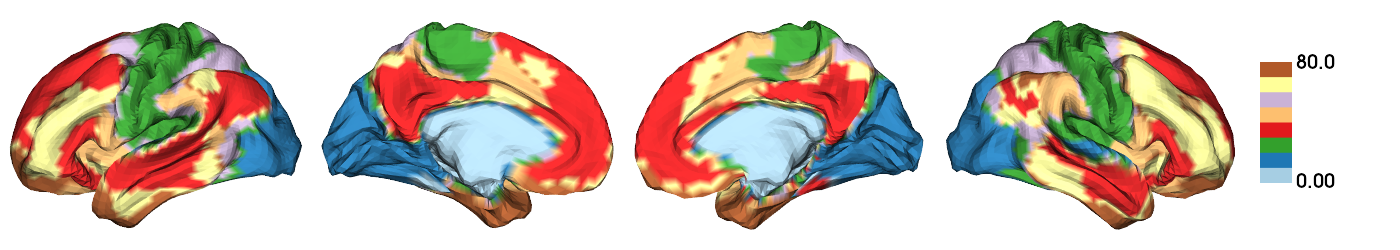

In [8]:
# Plot 7 networks
plot_hemispheres(f5k_lh, f5k_rh, yeo5k_7networks, cmap='Paired', nan_color=(0.1, 0.1, 0.1, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=(0, 80),
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

# Functional Connectome
## Degree centrality (*strength*) of $FC_{abs}$ 

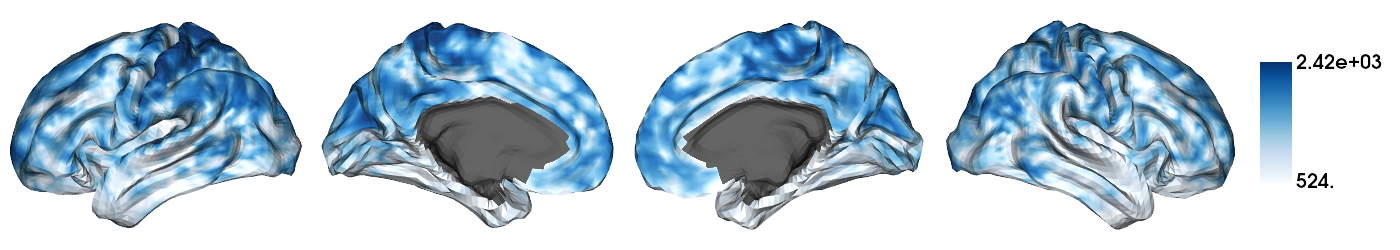

In [9]:
# Compute weighted degree centrality measures from the connectivity data
fc_ctx = np.sum(fc_abs, axis=0)

# Mask the midwall 
fc_ctx[mask_5k == False] = np.nan

# Calculate an optima range of color for visualization
crange=(np.quantile(fc_ctx[mask_5k != False], 0.01), np.quantile(fc_ctx[mask_5k != False], 0.99))

# plot the column mean of the mean connectome surface
plot_hemispheres(f5k_lh, f5k_rh, fc_ctx, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=crange,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

## $FC_{abs}$ original

(8856, 8856)
CPU times: user 1.86 s, sys: 461 ms, total: 2.32 s
Wall time: 2.34 s


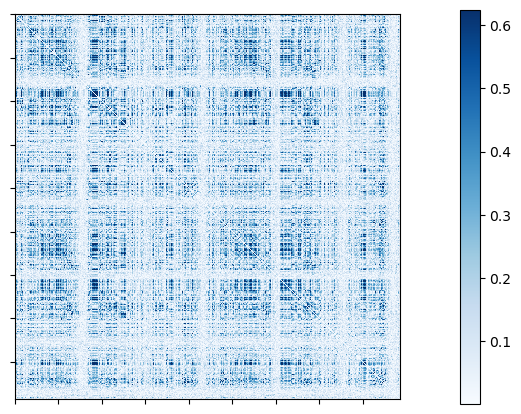

In [10]:
%%time
# Get the index of the non medial wall regions
indx = np.where(mask_5k==1)[0]

# Slice the connectome
fc_abs_masked=fc_abs[indx, :]
fc_abs_masked=fc_abs_masked[:, indx]

# Calculate the optimal range for visualization
crange=(np.quantile(fc_abs_masked, 0.01), np.quantile(fc_abs_masked, 0.99))

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(fc_abs_masked , figure=(5, 5), labels=None, cmap='Blues', vmin=crange[0], vmax=crange[1])
print(fc_abs_masked.shape)

## $FC_{abs}$ sorted by Yeo networks

(8917, 8917)
CPU times: user 1.05 s, sys: 416 ms, total: 1.46 s
Wall time: 1.46 s


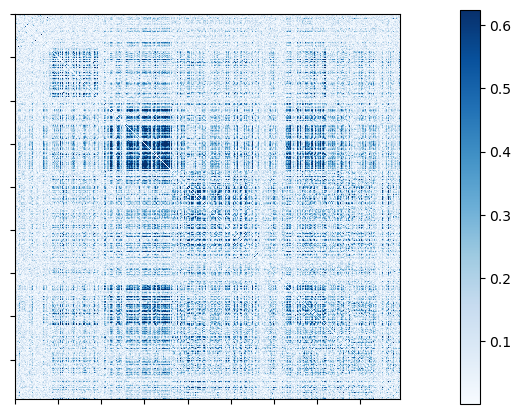

In [11]:
%%time
# Now, sort the connectome FC based on these indices
FC_sorted = fc_abs[yeo_sorted_indices, :][:, yeo_sorted_indices]  # Sort the SC matrix by the Yeo indices

# Slice the connectome
fc_sorted_masked=FC_sorted[yeo5k_7networks!=0, :]
fc_sorted_masked=fc_sorted_masked[:, yeo5k_7networks!=0]

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(fc_sorted_masked , figure=(5, 5), labels=None, cmap='Blues', vmin=crange[0], vmax=crange[1])
print(fc_sorted_masked.shape)

## $FC_{abs}$ sorted by degree centrality (weighted strengh)

CPU times: user 1.39 s, sys: 279 ms, total: 1.67 s
Wall time: 1.67 s


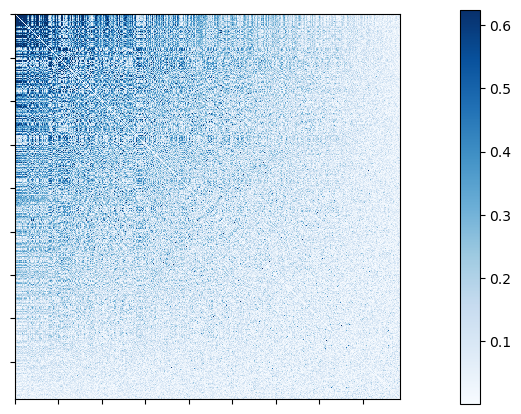

In [12]:
%%time

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(sort_matrix(fc_abs_masked, method='degree')[0] , figure=(5, 5), labels=None, cmap='Blues', vmin=crange[0], vmax=crange[1])


## $FC_{abs}$ sorted by Spectral Ordering

CPU times: user 39.3 s, sys: 3.01 s, total: 42.3 s
Wall time: 7.54 s


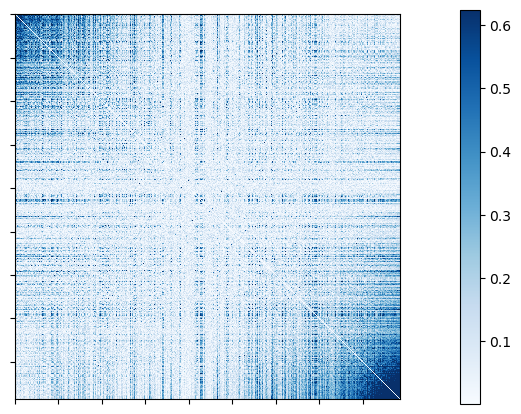

In [13]:
%%time

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(sort_matrix(fc_abs_masked, method='spectral')[0] , figure=(5, 5), labels=None, cmap='Blues', vmin=crange[0], vmax=crange[1])


## $FC_{abs}$ sorted by Modularity-Based Community Detection

CPU times: user 20min 53s, sys: 1min 1s, total: 21min 54s
Wall time: 21min 54s


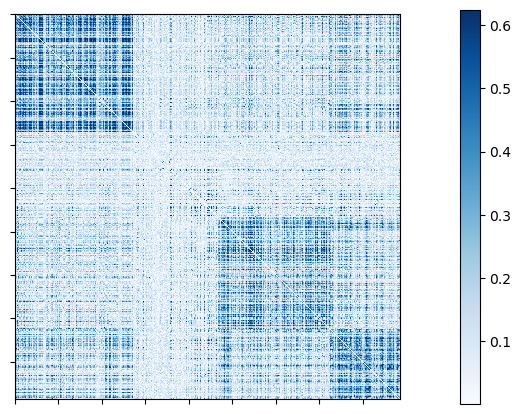

In [14]:
%%time

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(sort_matrix(fc_abs_masked, method='modularity')[0] , figure=(5, 5), labels=None, cmap='Blues', vmin=crange[0], vmax=crange[1])


## $FC_{abs}$ sorted by Multidimensional Scaling

CPU times: user 28min 40s, sys: 4min 52s, total: 33min 33s
Wall time: 12min 56s


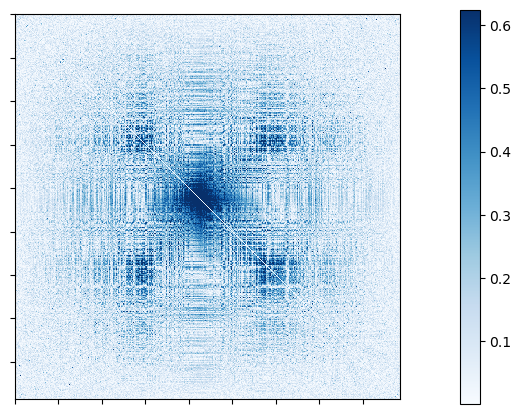

In [16]:
%%time

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(sort_matrix(fc_abs_masked, method='mds')[0] , figure=(5, 5), labels=None, cmap='Blues', vmin=crange[0], vmax=crange[1])


------------------------------------------
# Structural Connectomes

In [17]:
# Log transform the SC to improve visualization
sc_log = np.log(sc_sym+1)

# Calculate the Sum (strength) of the log transformed SC
sc_ctx = np.sum(sc_log, axis=0)

# Slice the connectome
sc_log_masked=sc_log[indx, :]
sc_log_masked=sc_log_masked[:, indx]

## $SC_{log}$ original

CPU times: user 811 ms, sys: 248 ms, total: 1.06 s
Wall time: 1.06 s


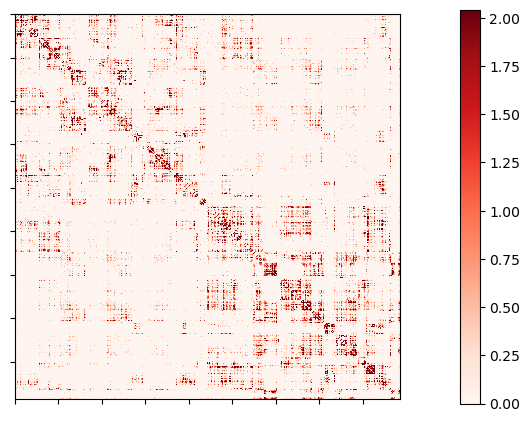

In [18]:
%%time
# Calculate the optimal range for visualization
crange=(np.quantile(sc_log_masked, 0.05), np.quantile(sc_log_masked, 0.99))

# Plot cortico-cortical connectivity matrices
plotting.plot_matrix(sc_log_masked , figure=(5, 5), labels=None, cmap='Reds', vmin=crange[0], vmax=crange[1])


## $SC_{log}$ sorted by yeo networks

In [19]:
%%time
# Now, sort the connectome SC based on these indices
SC_sorted = sc_log[yeo_sorted_indices, :][:, yeo_sorted_indices]  # Sort the SC matrix by the Yeo indices

# Slice the connectome
sc_sorted_masked=SC_sorted[yeo5k_7networks!=0, :]
sc_sorted_masked=sc_sorted_masked[:, yeo5k_7networks!=0]

# Plot cortico-cortical connectivity matrices
plotting.plot_matrix(sc_sorted_masked , figure=(5, 5), labels=None, cmap='Reds', vmin=crange[0], vmax=crange[1])


CPU times: user 975 ms, sys: 464 ms, total: 1.44 s
Wall time: 1.44 s


## $SC_{log}$ sorted by Degree centrality (weighted strengh)

CPU times: user 1.4 s, sys: 248 ms, total: 1.65 s
Wall time: 1.64 s


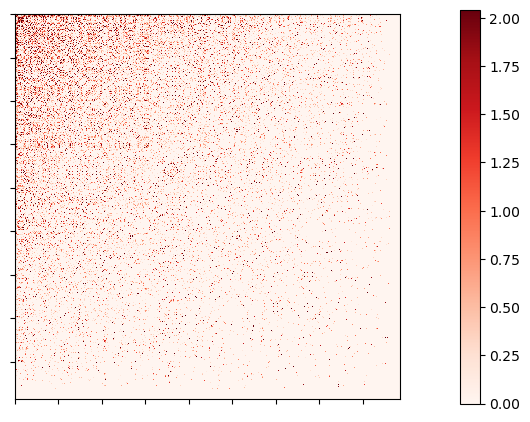

In [20]:
%%time

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(sort_matrix(sc_log_masked, method='degree')[0] , figure=(5, 5), labels=None, cmap='Reds', vmin=crange[0], vmax=crange[1])


## $SC_{log}$ sorted by Spectral ordering

CPU times: user 1min 2s, sys: 3.19 s, total: 1min 5s
Wall time: 5.99 s


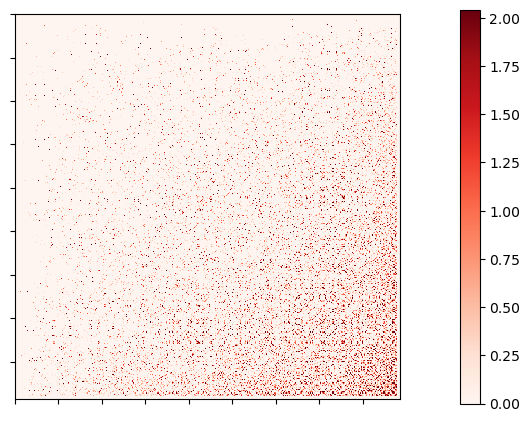

In [21]:
%%time

# Plot cortico-cortical connectivity matrices
plotting.plot_matrix(sort_matrix(sc_log_masked, method='spectral')[0] , figure=(5, 5), labels=None, cmap='Reds', vmin=crange[0], vmax=crange[1])


## $SC_{log}$ sorted by Modularity-Based Community Detection

CPU times: user 3min 37s, sys: 5.08 s, total: 3min 42s
Wall time: 3min 42s


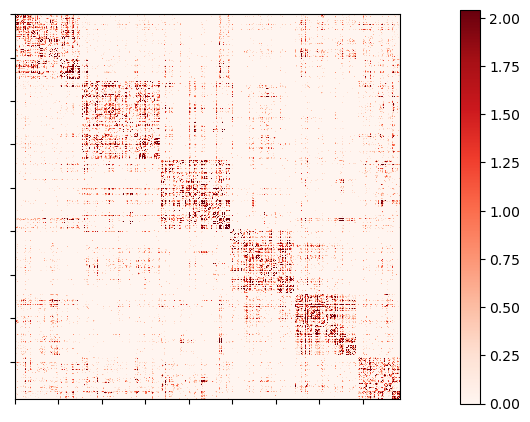

In [22]:
%%time

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(sort_matrix(sc_log_masked, method='modularity')[0] , figure=(5, 5), labels=None, cmap='Reds', vmin=crange[0], vmax=crange[1])


## $SC_{log}$ sorted by Multidimensional Scaling

CPU times: user 1h 25min 49s, sys: 14min 38s, total: 1h 40min 27s
Wall time: 38min 46s


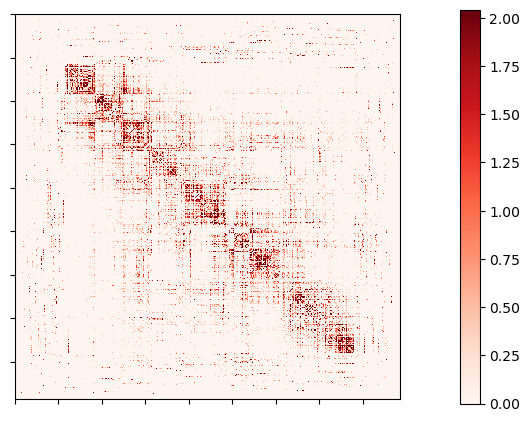

In [23]:
%%time

# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(sort_matrix(sc_log_masked, method='mds') , figure=(5, 5), labels=None, cmap='Reds', vmin=crange[0], vmax=crange[1])


_________________________________________________________________

## Degree centrality ($strength$) of $SC_{log}$ 

In [24]:
# Mask the midwall 
sc_ctx[mask_5k == False] = np.nan

# plot the column mean of the mean connectome surface
crange=(np.quantile(sc_ctx[mask_5k != False], 0.1), np.quantile(sc_ctx[mask_5k != False], 0.975))

plot_hemispheres(f5k_lh, f5k_rh, sc_ctx, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=crange,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

## Degree centrality ($strength_{log}$) of SC 

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_3557645/1577965135.py:5: RuntimeWarning: divide by zero encountered in log
  S_log = np.log(S)


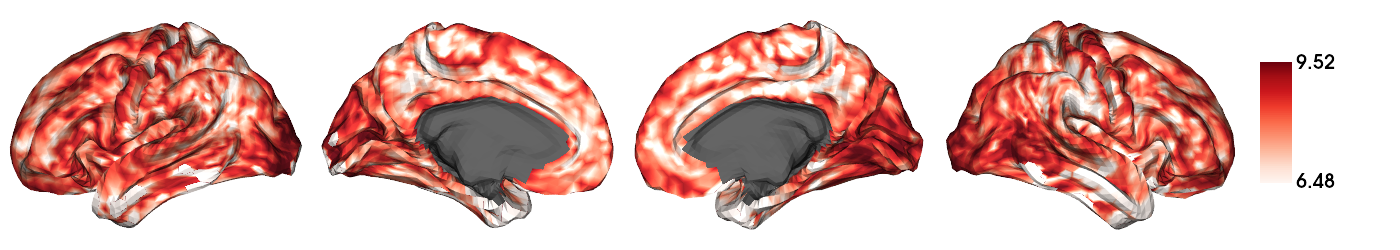

In [25]:
# Calculate the strength (S) from the SC
S = np.sum(sc_sym, axis=0)

# Log the S to normalize the values
S_log = np.log(S)

# Mask the midwall 
S_log[mask_5k == False] = np.nan

# plot the column mean of the mean connectome surface
crange=(np.quantile(S_log[mask_5k != False], 0.1), np.quantile(S_log[mask_5k != False], 0.975))

plot_hemispheres(f5k_lh, f5k_rh, S_log, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=crange,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

# Correlation between ($strength$) of $SC_{log}$ & ($strength_{log}$) of SC 

In [26]:
# Correlation calculation
corr, p_value = spearmanr(S_log[mask_5k != False], sc_ctx[mask_5k != False])

# Joint plot with marginal distributions
sns.set(style="whitegrid")
g = sns.jointplot(
    x=S_log[mask_5k != False], 
    y=sc_ctx[mask_5k != False], 
    kind='scatter', 
    color='#8B0000', 
    alpha=0.15,
    marginal_kws={'kde': True}  # Adds smooth KDE curves for marginal distributions
)

# LOWESS smoothing
lowess = sm.nonparametric.lowess(sc_ctx, S_log, frac=0.3)
g.ax_joint.plot(lowess[:, 0], lowess[:, 1], color='lightgray', linestyle='-', linewidth=2, alpha=0.75)

# Correlation legend
corr_text = f"Spearman r = {corr:.2f}, p = {p_value:.2e}"
g.ax_joint.legend([corr_text], fontsize=10)

# Axis labels and title
g.set_axis_labels('SC Strength_log', 'SC_log Strength', fontsize=12)
plt.suptitle('SC_log Strength vs SC Strength_log', fontsize=14)
plt.subplots_adjust(top=0.95)  # Adjust title position

plt.show()